In [23]:
import os
from collections import defaultdict
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import pickle as pkl
import sys


import warnings
warnings.filterwarnings("ignore") 


## Load Data

In [2]:
def load(opts):
    encoder = torch.load(os.path.join(opts.load, 'encoder.pt'))
    decoder = torch.load(os.path.join(opts.load, 'decoder.pt'))
    idx_dict = pkl.load(open(os.path.join(opts.load, 'idx_dict.pkl'), 'rb'))
    return encoder, decoder, idx_dict

def read_lines(filename):
    lines = open(filename).read().strip().lower().split('\n')
        

    return lines



def read_pairs(filename):
    """Reads lines that consist of two words, separated by a space.

    Returns:
        source_words: A list of the first word in each line of the file.
        target_words: A list of the second word in each line of the file.
    """
    lines = read_lines(filename)
    source_words, target_words = [], []
    for line in lines:
        line = line.strip()
        if line:
            source, target = line.split()
            source_words.append(source)
            target_words.append(target)
    return source_words, target_words



def all_alpha_or_dash(s):
    """Helper function to check whether a string is alphabetic, allowing dashes '-'.
    """
    return all(c.isalpha() or c == '-' for c in s)

def filter_lines(lines):
    """Filters lines to consist of only alphabetic characters or dashes "-".
    """
    return [line for line in lines if all_alpha_or_dash(line)]


def load_data():
    """Loads (English, Pig-Latin) word pairs, and creates mappings from characters to indexes."""

    source_lines, target_lines = read_pairs('data.txt')

    # Filter lines
    source_lines = filter_lines(source_lines)
    target_lines = filter_lines(target_lines)

    all_characters = set(''.join(source_lines)) | set(''.join(target_lines))

    
    # Create a dictionary mapping each character to a unique index
    char_to_index = { char: index for (index, char) in enumerate(sorted(list(all_characters))) }

    # Add start and end tokens to the dictionary
    start_token = len(char_to_index)
    end_token = len(char_to_index) + 1
    char_to_index['SOS'] = start_token
    char_to_index['EOS'] = end_token

    # Create the inverse mapping, from indexes to characters (used to decode the model's predictions)
    index_to_char = { index: char for (char, index) in char_to_index.items() }

    # Store the final size of the vocabulary
    vocab_size = len(char_to_index)

    line_pairs = list(set(zip(source_lines, target_lines)))  # Python 3

    idx_dict = { 'char_to_index': char_to_index,
                 'index_to_char': index_to_char,
                 'start_token': start_token,
                 'end_token': end_token }

    return line_pairs, vocab_size, idx_dict

def create_dict(pairs):
    """Creates a mapping { (source_length, target_length): [list of (source, target) pairs]
    This is used to make batches: each batch consists of two parallel tensors, one containing
    all source indexes and the other containing all corresponding target indexes.
    Within a batch, all the source words are the same length, and all the target words are
    the same length.
    """
    unique_pairs = list(set(pairs))  # Find all unique (source, target) pairs

    d = defaultdict(list)
    for (s,t) in unique_pairs:
        d[(len(s), len(t))].append((s,t))

    return d


def save_loss_plot(train_losses, val_losses, opts):
    """Saves a plot of the training and validation loss curves.
    """
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses)
    plt.plot(range(len(val_losses)), val_losses)
    plt.title('BS={}, nhid={}'.format(opts.batch_size, opts.hidden_size), fontsize=20)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(opts.checkpoint_path, 'loss_plot.pdf'))
    plt.close()



def checkpoint(encoder, decoder, idx_dict, opts):
    """Saves the current encoder and decoder models, along with idx_dict, which
    contains the char_to_index and index_to_char mappings, and the start_token
    and end_token values.
    """
    with open(os.path.join(opts.checkpoint_path, 'encoder.pt'), 'wb') as f:
        torch.save(encoder, f)

    with open(os.path.join(opts.checkpoint_path, 'decoder.pt'), 'wb') as f:
        torch.save(decoder, f)

    with open(os.path.join(opts.checkpoint_path, 'idx_dict.pkl'), 'wb') as f:
        pkl.dump(idx_dict, f)


        


### Utils for Preprocessing

In [3]:
def string_to_index_list(s, char_to_index, end_token):
    """Converts a sentence into a list of indexes (for each character).
    """
    return [char_to_index[char] for char in s] + [end_token]  # Adds the end token to each index list


def translate_sentence(sentence, encoder, decoder, idx_dict, opts):
    """Translates a sentence from English to Pig-Latin, by splitting the sentence into
    words (whitespace-separated), running the encoder-decoder model to translate each
    word independently, and then stitching the words back together with spaces between them.
    """
    if idx_dict is None:
      line_pairs, vocab_size, idx_dict = load_data()
    return ' '.join([translate(word, encoder, decoder, idx_dict, opts) for word in sentence.split()])


def translate(input_string, encoder, decoder, idx_dict, opts):
    """Translates a given string from English to Pig-Latin.
    """

    char_to_index = idx_dict['char_to_index']
    index_to_char = idx_dict['index_to_char']
    start_token = idx_dict['start_token']
    end_token = idx_dict['end_token']

    max_generated_chars = 20
    gen_string = ''

    indexes = string_to_index_list(input_string, char_to_index, end_token)
    indexes = to_var(torch.LongTensor(indexes).unsqueeze(0), opts.cuda)  # Unsqueeze to make it like BS = 1

    encoder_annotations, encoder_last_hidden = encoder(indexes)

    decoder_hidden = encoder_last_hidden
    decoder_input = to_var(torch.LongTensor([[start_token]]), opts.cuda)  # For BS = 1
    decoder_inputs = decoder_input

    for i in range(max_generated_chars):
      decoder_outputs, attention_weights = decoder(decoder_inputs, encoder_annotations, decoder_hidden)
      generated_words = F.softmax(decoder_outputs, dim=2).max(2)[1]
      ni = generated_words.cpu().numpy().reshape(-1)  # LongTensor of size 1
      ni = ni[-1] 

      decoder_inputs = torch.cat([decoder_input, generated_words], dim=1)
      
      if ni == end_token:
          break
      else:
          gen_string = "".join(
              [index_to_char[int(item)] 
               for item in generated_words.cpu().numpy().reshape(-1)])

    return gen_string

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
    

def to_var(tensor, cuda):
    """Wraps a Tensor in a Variable, optionally placing it on the GPU.

        Arguments:
            tensor: A Tensor object.
            cuda: A boolean flag indicating whether to use the GPU.

        Returns:
            A Variable object, on the GPU if cuda==True.
    """
    if cuda:
        return Variable(tensor.cuda())
    else:
        return Variable(tensor)


def create_dir_if_not_exists(directory):
    """Creates a directory if it doesn't already exist.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)





## Train

In [4]:

def training_loop(train_dict, val_dict, idx_dict, encoder, decoder, criterion, optimizer, opts):
    """Runs the main training loop; evaluates the model on the val set every epoch.
        * Prints training and val loss each epoch.
        * Prints qualitative translation results each epoch using TEST_SENTENCE
        * Saves an attention map for TEST_WORD_ATTN each epoch

    Arguments:
        train_dict: The training word pairs, organized by source and target lengths.
        val_dict: The validation word pairs, organized by source and target lengths.
        idx_dict: Contains char-to-index and index-to-char mappings, and start & end token indexes.
        encoder: An encoder model to produce annotations for each step of the input sequence.
        decoder: A decoder model (with or without attention) to generate output tokens.
        criterion: Used to compute the CrossEntropyLoss for each decoder output.
        optimizer: Implements a step rule to update the parameters of the encoder and decoder.
        opts: The command-line arguments.
    """

    start_token = idx_dict['start_token']
    end_token = idx_dict['end_token']
    char_to_index = idx_dict['char_to_index']

    loss_log = open(os.path.join(opts.checkpoint_path, 'loss_log.txt'), 'w')

    best_val_loss = 1e6
    train_losses = []
    val_losses = []

    for epoch in range(opts.nepochs):

        optimizer.param_groups[0]['lr'] *= opts.lr_decay
        
        train_loss = compute_loss(train_dict, encoder, decoder, idx_dict, criterion, optimizer, opts)
        val_loss = compute_loss(val_dict, encoder, decoder, idx_dict, criterion, None, opts)

        if val_loss < best_val_loss:
            checkpoint(encoder, decoder, idx_dict, opts)

        gen_string = translate_sentence(test_sentence, encoder, decoder, idx_dict, opts)
        print("Epoch: {:3d} | Train loss: {:.3f} | Val loss: {:.3f} | Gen: {:20s}".format(epoch, train_loss, val_loss, gen_string))

        loss_log.write('{} {} {}\n'.format(epoch, train_loss, val_loss))
        loss_log.flush()

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        save_loss_plot(train_losses, val_losses, opts)


def print_data_stats(line_pairs, vocab_size, idx_dict):
    """Prints example word pairs, the number of data points, and the vocabulary."""
    print('=' * 80)
    print('Data Stats'.center(80))
    print('-' * 80)
    for pair in line_pairs[:5]:
        print(pair)
    print('Num unique word pairs: {}'.format(len(line_pairs)))
    print('Vocabulary: {}'.format(idx_dict['char_to_index'].keys()))
    print('Vocab size: {}'.format(vocab_size))
    print('=' * 80)



def print_opts(opts):
    """Prints the values of all command-line arguments.
    """
    print('=' * 80)
    print('Opts'.center(80))
    print('-' * 80)
    for key in opts.__dict__:
        print('{:>30}: {:<30}'.format(key, opts.__dict__[key]).center(80))
    print('=' * 80)

def compute_loss(data_dict, encoder, decoder, idx_dict, criterion, optimizer, opts):
    start_token = idx_dict['start_token']
    end_token = idx_dict['end_token']
    char_to_index = idx_dict['char_to_index']

    losses = []
    for key in data_dict:
        input_strings, target_strings = zip(*data_dict[key])
        input_tensors = [torch.LongTensor(string_to_index_list(s, char_to_index, end_token)) for s in input_strings]
        target_tensors = [torch.LongTensor(string_to_index_list(s, char_to_index, end_token)) for s in target_strings]

        num_tensors = len(input_tensors)
        num_batches = int(np.ceil(num_tensors / float(opts.batch_size)))

        for i in range(num_batches):

            start = i * opts.batch_size
            end = start + opts.batch_size

            inputs = to_var(torch.stack(input_tensors[start:end]), opts.cuda)
            targets = to_var(torch.stack(target_tensors[start:end]), opts.cuda)
            BS = inputs.size(0)

            encoder_annotations, encoder_hidden = encoder(inputs)
            decoder_hidden = encoder_hidden

            start_vector = torch.ones(BS).long().unsqueeze(1) * start_token  
            decoder_input = to_var(start_vector, opts.cuda)  
            loss = 0.0

            seq_len = targets.size(1) 
            decoder_inputs = torch.cat([decoder_input, targets[:, 0:-1]], dim=1)  
            
            decoder_outputs, attention_weights = decoder(decoder_inputs, encoder_annotations, encoder_hidden)
            decoder_outputs_flatten = decoder_outputs.view(-1, decoder_outputs.size(2))
            targets_flatten = targets.view(-1)
            loss = criterion(decoder_outputs_flatten, targets_flatten)

            losses.append(loss.item())
            if optimizer:
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
    mean_loss = np.mean(losses)
    return mean_loss



### GRU cell

In [5]:
class MyGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MyGRUCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        # ------------
        # FILL THIS IN
        # ------------
        self.Wiz = nn.Linear(input_size, hidden_size, bias = False)
        self.Wir = nn.Linear(input_size, hidden_size, bias = False)
        self.Win = nn.Linear(input_size, hidden_size, bias = False)

        self.Whz = nn.Linear(hidden_size, hidden_size)
        self.Whr = nn.Linear(hidden_size, hidden_size)
        self.Whn = nn.Linear(hidden_size, hidden_size)
        


    def forward(self, x, h_prev):
        """Forward pass of the GRU computation for one time step.

        Arguments
            x: batch_size x input_size
            h_prev: batch_size x hidden_size

        Returns:
            h_new: batch_size x hidden_size
        """

        # ------------
        # FILL THIS IN
        # ------------
        z = F.sigmoid(self.Wiz(x) + self.Whz(h_prev))
        r = F.sigmoid(self.Wir(x) + self.Whr(h_prev))
        g = F.tanh(self.Win(x) + r * self.Whn(h_prev))
        h_new = (1-z)*g + z*h_prev
        return h_new

        

In [6]:
class GRUEncoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, opts):
        super(GRUEncoder, self).__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.opts = opts

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.gru = nn.GRUCell(hidden_size, hidden_size)

    def forward(self, inputs):
        """Forward pass of the encoder RNN.

        Arguments:
            inputs: Input token indexes across a batch for all time steps in the sequence. (batch_size x seq_len)

        Returns:
            annotations: The hidden states computed at each step of the input sequence. (batch_size x seq_len x hidden_size)
            hidden: The final hidden state of the encoder, for each sequence in a batch. (batch_size x hidden_size)
        """

        batch_size, seq_len = inputs.size()
        hidden = self.init_hidden(batch_size)

        encoded = self.embedding(inputs)  # batch_size x seq_len x hidden_size
        annotations = []

        for i in range(seq_len):
            x = encoded[:,i,:]  # Get the current time step, across the whole batch
            hidden = self.gru(x, hidden)
            annotations.append(hidden)

        annotations = torch.stack(annotations, dim=1)
        return annotations, hidden

    def init_hidden(self, bs):
        return to_var(torch.zeros(bs, self.hidden_size), self.opts.cuda)


class NoAttentionDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(NoAttentionDecoder, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.GRUCell(input_size=hidden_size, hidden_size=hidden_size)
        self.out = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs, annotations, hidden_init): 
        batch_size, seq_len = inputs.size()
        embed = self.embedding(inputs)       

        hiddens = []
        h_prev = hidden_init
        for i in range(seq_len):
            x = embed[:,i,:] 
            h_prev = self.rnn(x, h_prev) 
            hiddens.append(h_prev)
        hiddens = torch.stack(hiddens, dim=1) 
        output = self.out(hiddens)  
        return output, None      

### Splitting the Dataset and Training

In [7]:
def train(opts):
    line_pairs, vocab_size, idx_dict = load_data()
    print_data_stats(line_pairs, vocab_size, idx_dict)

    # Split the line pairs into an 80% train and 20% val split
    num_lines = len(line_pairs)
    num_train = int(0.8 * num_lines)
    train_pairs, val_pairs = line_pairs[:num_train], line_pairs[num_train:]

    # Group the data by the lengths of the source and target words, to form batches
    train_dict = create_dict(train_pairs)
    val_dict = create_dict(val_pairs)

    ##########################################################################
    ### Setup: Create Encoder, Decoder, Learning Criterion, and Optimizers ###
    ##########################################################################
    encoder = GRUEncoder(vocab_size=vocab_size, 
                         hidden_size=opts.hidden_size, 
                         opts=opts)

    if opts.decoder_type == 'rnn':
        decoder = NoAttentionDecoder(vocab_size=vocab_size, 
                             hidden_size=opts.hidden_size)
    elif opts.decoder_type == 'rnn_attention':
          decoder = RNNAttentionDecoder(vocab_size=vocab_size, 
                                      hidden_size=opts.hidden_size)
    else:
        raise NotImplementedError
        
    #### setup checkpoint path
    model_name = 'h{}-bs{}-{}'.format(opts.hidden_size, 
                                      opts.batch_size, 
                                      opts.decoder_type)
    opts.checkpoint_path = model_name
    create_dir_if_not_exists(opts.checkpoint_path)
    ####

    if opts.cuda:
        encoder.cuda()
        decoder.cuda()
        print("Moved models to GPU!")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=opts.learning_rate)

    try:
        training_loop(train_dict, val_dict, idx_dict, encoder, decoder, criterion, optimizer, opts)
    except KeyboardInterrupt:
        print('Exiting early from training.')
        return encoder, decoder
      
    return encoder, decoder


def compute_loss(data_dict, encoder, decoder, idx_dict, criterion, optimizer, opts):
    start_token = idx_dict['start_token']
    end_token = idx_dict['end_token']
    char_to_index = idx_dict['char_to_index']

    losses = []
    for key in data_dict:
        input_strings, target_strings = zip(*data_dict[key])
        input_tensors = [torch.LongTensor(string_to_index_list(s, char_to_index, end_token)) for s in input_strings]
        target_tensors = [torch.LongTensor(string_to_index_list(s, char_to_index, end_token)) for s in target_strings]

        num_tensors = len(input_tensors)
        num_batches = int(np.ceil(num_tensors / float(opts.batch_size)))

        for i in range(num_batches):
            start = i * opts.batch_size
            end = start + opts.batch_size
            inputs = to_var(torch.stack(input_tensors[start:end]), opts.cuda)
            targets = to_var(torch.stack(target_tensors[start:end]), opts.cuda)
            BS = inputs.size(0)
            encoder_annotations, encoder_hidden = encoder(inputs)
            decoder_hidden = encoder_hidden
            start_vector = torch.ones(BS).long().unsqueeze(1) * start_token  
            decoder_input = to_var(start_vector, opts.cuda) 
            loss = 0.0
            seq_len = targets.size(1) 
            decoder_inputs = torch.cat([decoder_input, targets[:, 0:-1]], dim=1)  
            decoder_outputs, attention_weights = decoder(decoder_inputs, encoder_annotations, encoder_hidden)
            decoder_outputs_flatten = decoder_outputs.view(-1, decoder_outputs.size(2))
            targets_flatten = targets.view(-1)
            loss = criterion(decoder_outputs_flatten, targets_flatten)
            losses.append(loss.item())
            if optimizer:
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
                        
    mean_loss = np.mean(losses)
    return mean_loss


def training_loop(train_dict, val_dict, idx_dict, encoder, decoder, criterion, optimizer, opts):
    """Runs the main training loop; evaluates the model on the val set every epoch.
        * Prints training and val loss each epoch.
        * Prints qualitative translation results each epoch using test_sentence
        * Saves an attention map for TEST_WORD_ATTN each epoch

    Arguments:
        train_dict: The training word pairs, organized by source and target lengths.
        val_dict: The validation word pairs, organized by source and target lengths.
        idx_dict: Contains char-to-index and index-to-char mappings, and start & end token indexes.
        encoder: An encoder model to produce annotations for each step of the input sequence.
        decoder: A decoder model (with or without attention) to generate output tokens.
        criterion: Used to compute the CrossEntropyLoss for each decoder output.
        optimizer: Implements a step rule to update the parameters of the encoder and decoder.
        opts: The command-line arguments.
    """

    start_token = idx_dict['start_token']
    end_token = idx_dict['end_token']
    char_to_index = idx_dict['char_to_index']

    loss_log = open(os.path.join(opts.checkpoint_path, 'loss_log.txt'), 'w')

    best_val_loss = 1e6
    train_losses = []
    val_losses = []

    for epoch in range(opts.nepochs):

        optimizer.param_groups[0]['lr'] *= opts.lr_decay
        
        train_loss = compute_loss(train_dict, encoder, decoder, idx_dict, criterion, optimizer, opts)
        val_loss = compute_loss(val_dict, encoder, decoder, idx_dict, criterion, None, opts)

        if val_loss < best_val_loss:
            checkpoint(encoder, decoder, idx_dict, opts)

        gen_string = translate_sentence(test_sentence, encoder, decoder, idx_dict, opts)
        print("Epoch: {:3d} | Train loss: {:.3f} | Val loss: {:.3f} | Gen: {:20s}".format(epoch, train_loss, val_loss, gen_string))

        loss_log.write('{} {} {}\n'.format(epoch, train_loss, val_loss))
        loss_log.flush()

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        save_loss_plot(train_losses, val_losses, opts)


### RNN Model Implemenetation

In [8]:
test_sentence="here hang a pearl in every cowslip ear"
torch.manual_seed(1)
args = AttrDict()
args_dict = {'cuda':True, 'nepochs':100, 'checkpoint_dir':"checkpoints", 'learning_rate':0.005, 'lr_decay':0.99,'batch_size':64, 'hidden_size':20, 'decoder_type': 'rnn'}
args.update(args_dict)
print_opts(args)
rnn_encoder, rnn_decoder = train(args)

                                      Opts                                      
--------------------------------------------------------------------------------
                                   cuda: 1                                      
                                nepochs: 100                                    
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.005                                  
                               lr_decay: 0.99                                   
                             batch_size: 64                                     
                            hidden_size: 20                                     
                           decoder_type: rnn                                    
                                   Data Stats                                   
--------------------------------------------------------------------------------
('sober', 'obersay')
('grey'

In [9]:
test_sentence = 'here hang a pearl in every asdbjhbahsjfkd edwqhhjkasdfaghjs adjhas dasjhgfaskjh'
long_sentence="here hang a pearl in every cowslip ear"
translated_RNN = translate_sentence(test_sentence, rnn_encoder, rnn_decoder, None, args)
long_translated_RNN = translate_sentence(long_sentence, rnn_encoder, rnn_decoder, None, args)
print("source:\t\t{} \ntranslated:\t{}".format(test_sentence, translated_RNN))
print("source:\t\t{} \ntranslated:\t{}".format(long_sentence, long_translated_RNN))

source:		here hang a pearl in every asdbjhbahsjfkd edwqhhjkasdfaghjs adjhas dasjhgfaskjh 
translated:	erehay anghay away ealepray inway everway asksay-ostingway undhusay-ationsway addjay-ousfay askuathlyjay
source:		here hang a pearl in every cowslip ear 
translated:	erehay anghay away ealepray inway everway ovinshay earway


### Model for Long sequences

In [10]:
long_sentence = 'here hang a pearl in every cowslip ear'
torch.manual_seed(1)
args_long = AttrDict()
 ## Changed Hidden Size from 20 to 40 to make it long on long sentences
args_dict_long = {'cuda':True, 'nepochs':100, 'checkpoint_dir':"checkpoints",
                  'learning_rate':0.005, 'lr_decay':0.99,'batch_size':64, 'hidden_size':40,
                  'decoder_type': 'rnn'}
args_long.update(args_dict_long)
print_opts(args_long)
rnn_encoder_long, rnn_decoder_long = train(args_long)

                                      Opts                                      
--------------------------------------------------------------------------------
                                   cuda: 1                                      
                                nepochs: 100                                    
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.005                                  
                               lr_decay: 0.99                                   
                             batch_size: 64                                     
                            hidden_size: 40                                     
                           decoder_type: rnn                                    
                                   Data Stats                                   
--------------------------------------------------------------------------------
('sober', 'obersay')
('grey'

In [11]:
test_sentence = 'here hang a pearl in every'
long_sentence="here hang a pearl in every cowslip ear"
translated_RNN_long = translate_sentence(test_sentence, rnn_encoder_long, rnn_decoder_long, None, args)
long_translated_RNN_long = translate_sentence(long_sentence, rnn_encoder_long, rnn_decoder_long, None, args)
print("source:\t\t{} \ntranslated:\t{}".format(test_sentence, translated_RNN_long))
print("source:\t\t{} \ntranslated:\t{}".format(long_sentence, long_translated_RNN_long))

source:		here hang a pearl in every 
translated:	eerhay anghay away earlday inway everyway
source:		here hang a pearl in every cowslip ear 
translated:	eerhay anghay away earlday inway everyway owspithway earway


## Attention Model Implementation

In [12]:
class RNNAttentionDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(RNNAttentionDecoder, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, hidden_size)

        self.rnn = MyGRUCell(input_size=hidden_size*2, hidden_size=hidden_size)
        self.attention = Attention(hidden_size=hidden_size)
        
        self.out = nn.Linear(hidden_size, vocab_size)

        
    def forward(self, inputs, annotations, hidden_init):
        """Forward pass of the attention-based decoder RNN.

        Arguments:
            inputs: Input token indexes across a batch for all the time step. (batch_size x decoder_seq_len)
            annotations: The encoder hidden states for each step of the input.
                         sequence. (batch_size x seq_len x hidden_size)
            hidden_init: The final hidden states from the encoder, across a batch. (batch_size x hidden_size)

        Returns:
            output: Un-normalized scores for each token in the vocabulary, across a batch for all the decoding time steps. (batch_size x decoder_seq_len x vocab_size)
            attentions: The stacked attention weights applied to the encoder annotations (batch_size x encoder_seq_len x decoder_seq_len)
        """
        
        batch_size, seq_len = inputs.size()
        embed = self.embedding(inputs)  # batch_size x seq_len x hidden_size        

        hiddens = []
        attentions = []
        h_prev = hidden_init
        for i in range(seq_len):
            
            embed_current = embed[:,i,:]
            context, attention_weights = self.attention(embed_current, annotations, annotations)
            embed_and_context = torch.cat((embed_current, context.squeeze(1)), 1)
            h_prev = self.rnn(embed_and_context,h_prev)

            
            hiddens.append(h_prev)
            attentions.append(attention_weights)

        hiddens = torch.stack(hiddens, dim=1) # batch_size x seq_len x hidden_size
        attentions = torch.cat(attentions, dim=2) # batch_size x seq_len x seq_len
        
        output = self.out(hiddens)  # batch_size x seq_len x vocab_size
        return output, attentions    

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()

        self.hidden_size = hidden_size

        self.Q = nn.Linear(hidden_size, hidden_size)
        self.K = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, hidden_size)
        self.softmax = nn.Softmax(dim=1)
        self.scaling_factor = torch.rsqrt(torch.tensor(self.hidden_size, dtype= torch.float))

    def forward(self, queries, keys, values):
        batch_size, seq_len, hidden_size = keys.size()
        q = self.Q(queries.view(-1, hidden_size)).view(batch_size, -1, hidden_size) #batch_size x (k) x hidden_size
        k = self.K(keys.view(-1,hidden_size)).view(batch_size, seq_len, hidden_size) #batch_size x seq_len x hidden_size
        v = self.V(values.view(-1, hidden_size)).view(batch_size, seq_len, hidden_size) #batch_size x seq_len x hidden_size
        unnormalized_attention = self.scaling_factor * torch.bmm(k, q.transpose(1,2)) #batch_size x seq_len x k
        attention_weights = self.softmax(unnormalized_attention) #batch_size x seq_len x k
        context = torch.bmm(attention_weights.transpose(1,2), v) #batch_size x k x hidden_size
        return context, attention_weights

In [13]:
warnings.filterwarnings("ignore") 
torch.manual_seed(1)
args_attn = AttrDict()
args_dict_attn = {'cuda':True,  'nepochs':100, 'checkpoint_dir':"checkpoints", 'learning_rate':0.005, 'lr_decay':0.99,'batch_size':64, 'hidden_size':20, 'decoder_type': 'rnn_attention' }
args_attn.update(args_dict_attn)
print_opts(args_attn)
attention_rnn_encoder, attention_rnn_decoder = train(args_attn)


                                      Opts                                      
--------------------------------------------------------------------------------
                                   cuda: 1                                      
                                nepochs: 100                                    
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.005                                  
                               lr_decay: 0.99                                   
                             batch_size: 64                                     
                            hidden_size: 20                                     
                           decoder_type: rnn_attention                          
                                   Data Stats                                   
--------------------------------------------------------------------------------
('sober', 'obersay')
('grey'

In [14]:
test_sentence = 'here hang a pearl in every'
long_sentence="here hang a pearl in every cowslip ear ever again hang in there for rest of the life"
translated_attn = translate_sentence(test_sentence, attention_rnn_encoder, attention_rnn_decoder, None, args)
long_translated_attn = translate_sentence(long_sentence, attention_rnn_encoder, attention_rnn_decoder, None, args)
print("source:\t\t{} \ntranslated:\t{}".format(test_sentence, translated_attn))
print("source:\t\t{} \ntranslated:\t{}".format(long_sentence, long_translated_attn))

source:		here hang a pearl in every 
translated:	ereray anghay away earlpay inway everyway
source:		here hang a pearl in every cowslip ear 
translated:	ereray anghay away earlpay inway everyway owslipcslay earway


#### Attention visualization

In [24]:
def visualize_attention(input_string, encoder, decoder, opts):
    """Generates a heatmap to show where attention is focused in each decoder step.
    """
    line_pairs, vocab_size, idx_dict = load_data()
    char_to_index = idx_dict['char_to_index']
    index_to_char = idx_dict['index_to_char']
    start_token = idx_dict['start_token']
    end_token = idx_dict['end_token']

    max_generated_chars = 20
    gen_string = ''

    indexes = string_to_index_list(input_string, char_to_index, end_token)
    indexes = to_var(torch.LongTensor(indexes).unsqueeze(0), opts.cuda)  # Unsqueeze to make it like BS = 1

    encoder_annotations, encoder_hidden = encoder(indexes)

    decoder_hidden = encoder_hidden
    decoder_input = to_var(torch.LongTensor([[start_token]]), opts.cuda)  # For BS = 1
    decoder_inputs = decoder_input

    produced_end_token = False

    for i in range(max_generated_chars):
     
      decoder_outputs, attention_weights = decoder(decoder_inputs, encoder_annotations, decoder_hidden)
      generated_words = F.softmax(decoder_outputs, dim=2).max(2)[1]
      ni = generated_words.cpu().numpy().reshape(-1)  # LongTensor of size 1
      ni = ni[-1] 
      
      decoder_inputs = torch.cat([decoder_input, generated_words], dim=1)
      
      if ni == end_token:
          break
      else:
          gen_string = "".join(
              [index_to_char[int(item)] 
               for item in generated_words.cpu().numpy().reshape(-1)])
    
    if isinstance(attention_weights, tuple):
      
      attention_weights, self_attention_weights = attention_weights
    
    all_attention_weights = attention_weights.data.cpu().numpy()
    
    for i in range(len(all_attention_weights)):
      attention_weights_matrix = all_attention_weights[i].squeeze()
      fig = plt.figure()
      ax = fig.add_subplot(111)
      cax = ax.matshow(attention_weights_matrix, cmap='bone')
      fig.colorbar(cax)

      # Set up axes
      ax.set_yticklabels([''] + list(input_string) + ['EOS'], rotation=90)
      ax.set_xticklabels([''] + list(gen_string) + (['EOS'] if produced_end_token else []))

      # Show label at every tick
      ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
      ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
      # Add title
      plt.xlabel('Attention weights to the source sentence in layer {}'.format(i+1))
      plt.tight_layout()
      plt.grid('off')
      plt.show()
      plt.savefig('save.pdf')
      plt.close(fig)

    return gen_string


In [25]:
words = 'roomba'

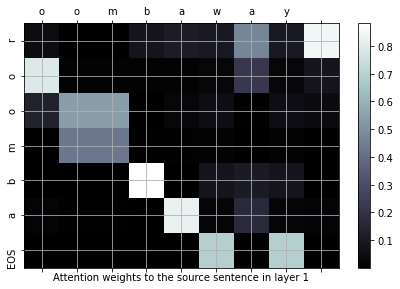

'oombaway'

<Figure size 432x288 with 0 Axes>

In [27]:
visualize_attention(words, attention_rnn_encoder, attention_rnn_decoder,args_attn)